In [1]:
import os
import math
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ..logistic_regression.traditional_method.preprocess import make_multiple_hard_labels

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-byiggk38 because the default path (/home/guest/r11922a05/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


ImportError: attempted relative import with no known parent package

In [2]:
DATA_ROOT = os.path.join(
    Path(os.getcwd()).parent.absolute(), 'hahow', 'data'
)

user_csv_path = os.path.join(DATA_ROOT, 'users.csv')
course_chapter_item_csv_path = os.path.join(DATA_ROOT, 'course_chapter_items.csv')
courses_csv_path = os.path.join(DATA_ROOT, 'courses.csv')
subgroup_csv_path = os.path.join(DATA_ROOT, 'subgroups.csv')
train_group_csv_path = os.path.join(DATA_ROOT, 'train', 'train_group.csv')
train_csv_path = os.path.join(DATA_ROOT, 'train', 'train.csv')

In [3]:
user_df = pd.read_csv(user_csv_path)
course_chapter_item_df = pd.read_csv(course_chapter_item_csv_path)
courses_df = pd.read_csv(courses_csv_path)
subgroup_df = pd.read_csv(subgroup_csv_path)
train_group_df = pd.read_csv(train_group_csv_path)
train_df = pd.read_csv(train_csv_path)

# Idea
- Unseen代表user沒有在`train.csv`或`train_group.csv`中出現，但還是有user profile
- `course_chapter_item.csv`
    - 把每一個章節的video_length_in_seconds合併起來成一個course的長度
    - 把每一個course所有的chapterm_name和chapter_item_name的全部concat丟到一個Encoder變成Embedding
- `courses.csv` 重要的資料
    - Group 1 (一進去網站會看到的)
        - `course_name`
        - `course_price`
    - Group 2 (點進去課程的前段到中段)
        - `will_learn`
        - `desciption`
        - `required_tools`
        - `recommended_background`
        - `target_group`
    - Group 3 (要拉到很下面才會看到)
        - `teacher_id`:
        - `teacher_intro`
    - ?
        - `course_published_at_local`: 時間越長大家越不想買？或是課程早就沉到下面去了？
- Model
    - target_group and user interests compute similarity -> calculate which course the user will buy

In [10]:
user_df['gender'].isna().sum() / user_df.shape[0], \
user_df['occupation_titles'].isna().sum() / user_df.shape[0], \
user_df['interests'].isna().sum() / user_df.shape[0], \
user_df['recreation_names'].isna().sum() / user_df.shape[0]

(0.34614677634299895,
 0.7774612073587305,
 0.36617496132224314,
 0.755411056477184)

# User
- `user_id`: id for identifying each user
- `gender`: # of category = 3, [female, male, other]
- `occupation_titles`: a user could have **several** occupations, there are a total of **20** occupations
- `interests`: a user could have **serveral** interests, interests could be divided into main interest and subinterest (e.g. mainInterest_subInterest = 語言_英文)
    - main interest: 12 categories
    - sub interest: 95 categories
    - see `sub_int_cnt` variable for {main_interest:sub_interest} mapping
- `recreation_names`: a user could have **several** recreations, there are a total of **31** recreations

In [10]:
user_df.columns, user_df.shape, user_df.head(10)

(Index(['user_id', 'gender', 'occupation_titles', 'interests',
        'recreation_names'],
       dtype='object'),
 (130566, 5),
                     user_id  gender      occupation_titles  \
 0  54ccaa73a784960a00948687  female                    NaN   
 1  54dca4456d7d350900e86bae    male                    NaN   
 2  54e421bac5c9c00900cd8d47  female                    NaN   
 3  54e961d4c5c9c00900cd8d84   other                    金融業   
 4  54e9b744c5c9c00900cd8d8a   other  資訊科技,法律、社會及文化專業,非營利組織   
 5  54eac49bc5c9c00900cd8d95    male                    NaN   
 6  54ef3499b839040f0001607d    male                    NaN   
 7  54ef34e2b839040f00016086  female                    NaN   
 8  54ef354db839040f0001608b   other               藝文設計,自由業   
 9  54ef3574b839040f0001608f  female           藝文設計,出版業,自由業   
 
                                            interests     recreation_names  
 0  職場技能_創業,藝術_電腦繪圖,設計_介面設計,設計_動態設計,設計_平面設計,投資理財_投...                  NaN  
 1  設計_動態設計,設計_平面設計,設

In [13]:
unique_user = user_df['user_id'].unique()
len(unique_user), user_df.shape[0]
# No repeated user

(130566, 130566)

In [18]:
for col in user_df.columns:
    if col != 'user_id':
        category_ratio = user_df[col].value_counts() / user_df.shape[0]
        print(f"Column name: {col}")
        print(category_ratio)
        print("="*20)

Column name: gender
female    0.415905
male      0.225794
other     0.012155
Name: gender, dtype: float64
Column name: occupation_titles
其他                    0.018818
服務業                   0.017171
資訊科技                  0.015908
製造業                   0.013296
藝文設計                  0.011190
                        ...   
公務人員,法律、社會及文化專業,退休    0.000008
資訊科技,退休               0.000008
製造業,非營利組織,其他          0.000008
出版業,金融業,服務業           0.000008
金融業,家管,醫療             0.000008
Name: occupation_titles, Length: 851, dtype: float64
Column name: interests
生活品味_烹飪料理與甜點                                                                                     0.005775
語言_英文                                                                                            0.005093
藝術_繪畫與插畫                                                                                         0.003914
語言_日文                                                                                            0.003301
手作_更多手作               

In [8]:
occu_set = set()
for occu in user_df['occupation_titles']:
    if type(occu) == str:
        if ',' in occu:
            occu_split = occu.split(',')
            occu_set.update(occu_split)
        else:
            occu_set.update([occu])
len(occu_set)


20

In [32]:
main_int_set = set()
sub_int_set = set()
main_sub_dict = dict()

for interest in user_df['interests']:
    if type(interest) == str:
        # user has several interests
        if ',' in interest:
            int_split = interest.split(',')
            for int_ in int_split:
                main_int = int_.split('_')[0]
                sub_int = int_.split('_')[1]
                main_int_set.update([main_int])
                sub_int_set.update([sub_int])

                if main_int not in main_sub_dict.keys():
                    main_sub_dict[main_int] = set([sub_int])
                else:
                    main_sub_dict[main_int].update([sub_int])
        # user have only one interest
        else:
            main_int = interest.split('_')[0]
            sub_int = interest.split('_')[1]
            main_int_set.update([main_int])
            sub_int_set.update([sub_int])

            if main_int not in main_sub_dict.keys():
                main_sub_dict[main_int] = set([sub_int])
            else:
                main_sub_dict[main_int].update([sub_int])

In [30]:
len(main_int_set), main_int_set

(12,
 {'人文',
  '手作',
  '投資理財',
  '攝影',
  '生活品味',
  '程式',
  '職場技能',
  '藝術',
  '行銷',
  '設計',
  '語言',
  '音樂'})

In [31]:
len(sub_int_set), sub_int_set

(95,
 {'AI 人工智慧',
  'DJ',
  '人聲',
  '介面設計',
  '個人品牌經營',
  '刺繡',
  '創業',
  '動態攝影',
  '動態設計',
  '區塊鏈',
  '商業攝影',
  '壓力舒緩',
  '字體設計',
  '寵物',
  '居家',
  '平面設計',
  '影像創作',
  '影視創作',
  '後製剪輯',
  '心靈成長與教育',
  '應用設計',
  '手作小物',
  '手寫字',
  '手工印刷',
  '手工書',
  '手機程式開發',
  '投資觀念',
  '攝影理論',
  '效率提升',
  '數位行銷',
  '數學',
  '數據分析',
  '文學',
  '文書處理',
  '文案',
  '日文',
  '更多人文',
  '更多手作',
  '更多投資理財',
  '更多攝影',
  '更多生活品味',
  '更多程式',
  '更多職場技能',
  '更多藝術',
  '更多行銷',
  '更多設計',
  '更多語言',
  '更多音樂',
  '樂器',
  '模型',
  '歐洲語言',
  '比特幣',
  '氣球',
  '求職',
  '烹飪料理與甜點',
  '獨立接案',
  '理財',
  '產品設計',
  '社會科學',
  '社群行銷',
  '程式入門',
  '程式思維',
  '程式理財',
  '程式語言',
  '篆刻',
  '素描',
  '網站架設',
  '網頁前端',
  '網頁後端',
  '網頁設計',
  '繪畫與插畫',
  '翻譯',
  '職場溝通',
  '色彩學',
  '英文',
  '表演藝術',
  '西班牙文',
  '親子教育',
  '角色設計',
  '設計理論',
  '護膚保養與化妝',
  '資料彙整',
  '資料科學',
  '資訊安全',
  '軟體程式開發與維護',
  '遊戲開發',
  '運動',
  '量化交易',
  '量化分析',
  '金融商品',
  '電腦繪圖',
  '靈性發展',
  '韓文',
  '音樂創作',
  '音樂理論'})

In [33]:
sub_int_cnt = 0
for main_int, sub_int in main_sub_dict.items():
    sub_int_cnt += len(sub_int)
    print(main_int, len(sub_int))
sub_int_cnt

職場技能 10
藝術 9
設計 7
投資理財 6
行銷 5
程式 16
音樂 6
攝影 7
語言 7
生活品味 11
手作 8
人文 3


95

In [36]:
rec_set = set()
for rec in user_df['recreation_names']:
    if type(rec) == str:
        if ',' in rec:
            rec_split = rec.split(',')
            rec_set.update(rec_split)
        else:
            rec_set.update([rec])
len(rec_set), rec_set

(31,
 {'區塊鏈',
  '占卜',
  '寫作',
  '手作',
  '手寫字',
  '手遊',
  '插畫',
  '插花',
  '政治經濟',
  '旅行旅遊',
  '書法',
  '桌遊',
  '棋類遊戲',
  '水彩',
  '狗派',
  '瑜珈',
  '社會服務',
  '素描',
  '美容妝髮',
  '舞台劇',
  '舞蹈',
  '貓派',
  '速寫',
  '運動健身',
  '運動賽事',
  '金融理財',
  '閱讀',
  '電影',
  '電玩',
  '電腦繪圖',
  '電視劇'})

# Course Chapter Item
(group-subgroup-subsubgroup)
- `course_id`: id to identify each course
- `chapter_no`: number to identify a chapter in a course (a course could have several chapters)
- `chapter_id`: unique id to identify chapter in each course
- `chapter_name`: name of the chapter (not really important?)
    - may contain features to attract user
- `chapter_item_id`: unique id to identify a item in a chapter
- `chapter_item_name`: name of the item (not really important?)
- `chapter_item_type`: type of an item, has only two categories [LECTURE, ASSIGNMENT]
    - useless?
- `video_length_in_seconds`: the length of video in each **item**
    - the total length of a `course` may affect the willingness of an user to by this course

In [8]:
course_chapter_item_df.columns, \
    course_chapter_item_df.shape, \
        course_chapter_item_df.head()

(Index(['course_id', 'chapter_no', 'chapter_id', 'chapter_name',
        'chapter_item_id', 'chapter_item_no', 'chapter_item_name',
        'chapter_item_type', 'video_length_in_seconds'],
       dtype='object'),
 (21290, 9),
                   course_id  chapter_no                chapter_id  \
 0  54d5a117065a7e0e00725ac0           1  5c91835bed65c200740eefda   
 1  54d5a117065a7e0e00725ac0           1  5c91835bed65c200740eefda   
 2  54d5a117065a7e0e00725ac0           1  5c91835bed65c200740eefda   
 3  54d5a117065a7e0e00725ac0           1  5c91835bed65c200740eefda   
 4  54d5d9952246e60a009ec571           1  5c91835bed65c200740eefdb   
 
   chapter_name           chapter_item_id  chapter_item_no chapter_item_name  \
 0      本課程不分章節  5a1e172da2c4b000589dc7f2                1               拉曲線   
 1      本課程不分章節  5a1e172da2c4b000589dc7f3                2              分割工具   
 2      本課程不分章節  5a1e172da2c4b000589dc7f4                3           油漆桶上色工具   
 3      本課程不分章節  5a1e172da2c4b00

In [11]:
unique_course = course_chapter_item_df['course_id'].unique()
len_uni_cour = len(unique_course)
print(f"There are a total of {len_uni_cour} courses")

There are a total of 727 courses


In [20]:
course_chapter_item_df['chapter_name'].value_counts()

本課程不分章節               5862
此課程無章節                  78
課程內容                    53
YouTuber 的 36 堂課        45
基礎知識篇                   42
                      ... 
原油引言                     1
  黃金引言                   1
破解！網友與彩妝師公認的『上妝困擾』       1
大播客時代來了                  1
特別章節                     1
Name: chapter_name, Length: 2702, dtype: int64

In [24]:
course_chapter_item_df['chapter_item_name'].value_counts().sort_values()[20:]

開啟說話雷達，面試前你應該要知道的事！                  1
嘻哈歌曲如何算拍子、Extended歌曲介紹、itunes找素材     1
兩首extended歌曲接歌實作1                    1
兩首extended歌曲接歌實作2                    1
總結：作業製作方法                            1
                                    ..
結語                                  11
章節介紹與案例解析                           12
課程總結                                12
前言                                  14
重點統整                                33
Name: chapter_item_name, Length: 20716, dtype: int64

In [18]:
course_chapter_item_df['chapter_item_type'].value_counts()

LECTURE       18977
ASSIGNMENT     2313
Name: chapter_item_type, dtype: int64

# Courses
- data shape = (728, 14)
- `course_id`: id for identifying a course
- `course_name`: the name of the course
    - use chinese sentence BERT
- `course_price`: the price of a course
    - 16 courses are **free**
    - most of the courses cost less than 3000
- `teacher_id`: id for identifying a teacher
    - 553 teachers
    - useless, since {id:intro} is 1-to-1
- `teacher_intro`: the intro of a teacher
    - text data
    - use chinese sentence bert
    - may do teacher clustering -> assign group
- `groups`: the group to which the course belongs to
    - A course could correspond to **many groups**
    - number of groups: 12
    - use FastText
- `sub_groups`: the subgroup to which the course belongs to
    - A course could correspond to **many subgroups**
    - number of subgroups: 91 (correspond to subgroup.csv)
- `topics`: the topic to which the course belongs to
    - A course could correspond to **many topics**
    - number of topics: 201
- `course_published_at_local`: 該課程識別 ID 的發行時間
- `description`: 課程詳情
    - most of them are pictures -> could encode img feature?
- `will_learn`: what you could learn in this course
    - text data
- `required_tools`: what you need to prepare for this course
    - text data
- `recommended_background`: what kind
- `target_group`:哪些人適合這堂課
    - descriptive text

### Important varaible
- Group 1 (一進去網站會看到的)
    - `course_name`
    - `course_price`
- Group 2 (點進去課程的前段到中段)
    - `will_learn`
    - `desciption`
    - `required_tools`
    - `recommended_background`
    - `target_group`
- Group 3 (要拉到很下面才會看到)
    - `teacher_id`:
    - `teacher_intro`

In [4]:
courses_df.columns, \
    courses_df.shape, \
        courses_df.head()

(Index(['course_id', 'course_name', 'course_price', 'teacher_id',
        'teacher_intro', 'groups', 'sub_groups', 'topics',
        'course_published_at_local', 'description', 'will_learn',
        'required_tools', 'recommended_background', 'target_group'],
       dtype='object'),
 (728, 14),
                   course_id           course_name  course_price  \
 0  61888e868f154b000781b45a  少女人妻華麗變身：七大妝容七彩的夢幻樂園          1800   
 1  54d5a117065a7e0e00725ac0         幾何圖形分割 X 色塊組合           100   
 2  54d5d9952246e60a009ec571               數位拼貼的手感           300   
 3  54d7148a2246e60a009ec588        Line 的貼圖自己動手做！           185   
 4  5513e92b38239d10005778e1        為申請學校或工作寫好英文自傳           600   
 
                  teacher_id  \
 0  61888e7bb7fe1c0006850eff   
 1  54d5a079065a7e0e00725abe   
 2  54cb5c2ea784960a00948678   
 3  54d713532246e60a009ec586   
 4  5513e92438239d10005778df   
 
                                        teacher_intro   groups      sub_groups  \
 0  在美妝 KOL 圈裡屬個人風

In [7]:
unique_course = courses_df['course_id'].value_counts()
len(unique_course) == courses_df.shape[0]
# no repeated courses

True

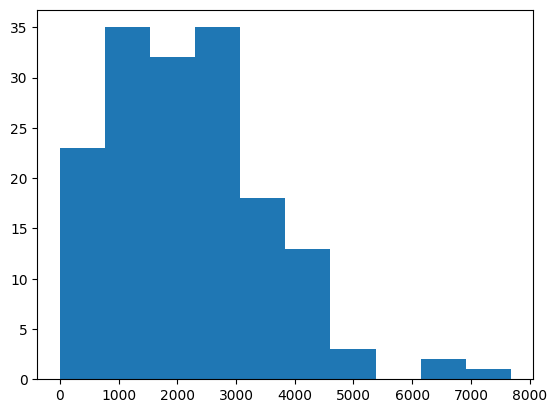

In [30]:
x = courses_df['course_price'].value_counts().index
y = courses_df['course_price'].value_counts().values
plt.hist(x)
plt.show()

In [23]:
courses_df[
    courses_df['course_price'] == 0
].shape[0]

16

In [41]:
unique_teacher = courses_df['teacher_id'].value_counts().sort_values(ascending=False)
len(unique_teacher)

(553,
 59a7c873cd57920700558c12    7
 5afa5a0ebb4174001e3fe107    6
 5f7c1de062ad22eb607a1a00    6
 5bdaa4f20e5a400020262571    6
 5e95a2f25161cf0190d3f918    6
                            ..
 61306f811bf9240007a80b1d    1
 60b90c67c5c9fb5a82a26fbd    1
 6130492bd5d02a00071f2be5    1
 60ebb977fa79d90007aeaa3e    1
 607949f02a7cba788738f1eb    1
 Name: teacher_id, Length: 553, dtype: int64)

In [43]:
courses_df[courses_df['teacher_id'] == '59a7c873cd57920700558c12']

,course_id,course_name,course_price,teacher_id,teacher_intro,groups,sub_groups,topics,course_published_at_local,description,will_learn,required_tools,recommended_background,target_group
163,59c1c8c84c36510700f925b2,三小時學會拆解社會現象與新聞議題！,990,59a7c873cd57920700558c12,我是筆名人渣文本的專欄作家周偉航，希望能把各種學術專業知識以最簡單實用的方式告訴大家~\n\...,人文,社會科學,社會科學,2018-01-13 12:00:03.270,<p>從只是「看新聞」到能夠「講新聞」，你差的就是這一門課！</p><p><br /></p...,對新聞事件與社會議題能快速判斷各方論點是否健全，看出誰是亂虎爛的假貨。當然，最重要的是能有效...,沒有耶。不然準備紙筆好了，無聊時可以畫烏龜。,最好識字哦！不識字也要聽得懂人話。,關心時事，但沒空讀一堆政治、社會、哲學經典名著的善良百姓。邪惡百姓也可以啦。
198,5aaf2dad1e4ee6001e9632fd,三小時教你怎麼講道德不輸人,1200,59a7c873cd57920700558c12,我是筆名人渣文本的專欄作家周偉航，希望能把各種學術專業知識以最簡單實用的方式告訴大家~\n\...,人文,社會科學,社會科學,2018-07-10 12:00:34.852,<p>老是被人嗆說不懂「倫理」嗎？每次和人爭論「道德」對錯的時候，總感覺自己是個蠢人嗎？不要...,可針對現實道德衝突提出明確意見，或是通過大學部通識課程與同等級的專業倫理學測驗。,帶腦來就好。,聽得懂中文。,其實人人都需要，但更適合那些對現實道德衝突與解決方案頗有興趣的人。
302,5cac9bd2d133060020f42ab4,職場必備的批判思考力：基礎篇,499,59a7c873cd57920700558c12,我是筆名人渣文本的專欄作家周偉航，希望能把各種學術專業知識以最簡單實用的方式告訴大家~\n\...,"人文,職場技能","更多職場技能,社會科學","更多職場技能,社會科學",2019-07-22 11:57:28.890,<p>職涯大師愛談獨立思考，老闆主管也要大家多多動腦，但你就是辦不到，到底該如何是好？</p...,足以分析日常語句，找出其中可能問題，並提出最基本的解決方案。,本課程無特定工具需求。,國民教育程度即可。,1. 常被評為不具獨立思考能力。\n2. 很難在論戰中取勝。\n3. 不太能把握到事情的重點...
327,5cee252cea2d0500209c0b8e,職場必備的批判思考力：創意力篇,499,59a7c873cd57920700558c12,我是筆名人渣文本的專欄作家周偉航，希望能把各種學術專業知識以最簡單實用的方式告訴大家~\n\...,"人文,職場技能","更多人文,更多職場技能","更多人文,更多職場技能",2019-09-27 11:57:57.233,<h4>人生短短幾個秋<b>，每天生活不就這樣，啊創意是什麼？能吃嗎？</b></h4><i...,在不刻意增加生活知能的狀況下，由現有人生經驗與知識創造出有價值的新概念或新方法。,本課程無特定工具需求。,國民教育程度即可。有上過「職場必備的批判思考力：基礎篇」也能有幫助哦,1. 缺乏創意。\n2. 覺得工作或生活一成不變。\n3. 事業發展碰到瓶頸急需突破。\n4...
352,5d80dde645639e00212d81a5,職場必備的批判思考力：論戰力篇,499,59a7c873cd57920700558c12,我是筆名人渣文本的專欄作家周偉航，希望能把各種學術專業知識以最簡單實用的方式告訴大家~\n\...,"人文,職場技能","更多職場技能,社會科學","更多職場技能,社會科學",2019-12-13 17:28:11.655,<p>逢年過節，總是被親戚的尬聊擊潰？</p><p>碰到推銷傳教，老是乖乖先聽一波？</p>...,強化溝通表達能力，包括判斷是否該發表意見，如何有效傳達自身想法，針對他人主張該如何快速反應，...,本課程無特定工具需求。,國民教育程度即可。曾上過「職場必備的批判思考力：基礎篇」也能有幫助哦！,1.對溝通能力缺乏自信。\n2.無法精準展示自身想法。\n3.難以回應自身無法認同的主張。\...
375,5dff3b91f066100021955305,職場必備的批判思考力：反省力篇,499,59a7c873cd57920700558c12,我是筆名人渣文本的專欄作家周偉航，希望能把各種學術專業知識以最簡單實用的方式告訴大家~\n\...,"人文,職場技能","更多職場技能,社會科學","更多職場技能,社會科學",2020-02-27 11:53:15.313,<p>孔子說「吾日三省吾身」，但你一直都沒認真反省過人生嗎？</p><p>你總是感嘆「人生就...,強化綜合反省能力，包括確認自身立場，分析推論過程，檢測觀點強度，跳出惡性循環，並確保結論能對...,本課程無特定工具需求。,國民教育程度即可。曾上過「職場必備的批判思考力：基礎篇」還能更快上手！,1.總是不斷後悔卻無力改變。\n2.不太清楚失敗的原因。\n3.一再被批判卻難以徹底改變。\...
459,5ebce244df2168d2c1d83995,職場必備的批判思考力：沉思力篇,499,59a7c873cd57920700558c12,我是筆名人渣文本的專欄作家周偉航，希望能把各種學術專業知識以最簡單實用的方式告訴大家~\n\...,"人文,職場技能","社會科學,職場溝通","口語表達,社會科學",2020-08-31 11:48:46.737,<h4>課程緣起</h4><p>老闆要你好好想一想，但你怎麼想，大腦都是一片空白嗎？</p>...,提升深度思考的能力，包括營造有利沉思的時空、提升集中力、掌握自我主張、強化記憶聯想與推理力、...,本課程無特定工具需求。,國民教育程度即可。曾上過「職場必備的批判思考力：基礎篇」還能更快上手！,1.常因緊張而錯過反應時機。\n2.有動腦需求時，大腦卻是一片空白。\n3.思考效率低，總是...


In [38]:
courses_df['teacher_intro']

0      在美妝 KOL 圈裡屬個人風格強烈的 Alice，在清新與叛逆風格間遊刃有餘，其幽默的美妝影...
1      從學生時代開始摸索photoshop等軟體，自以為有些天賦但後來發現其實沒有。出社會後從事美...
2      自由工作者，致力於品牌視覺規劃，包含識別系統設計、平面設計、包裝設計、網頁、插畫製作等，偶爾...
3      我是Danny，現是一名自由接案的插畫師，主要是做插畫設計、人物設計、App UI設計，20...
4      在北美長大，回到南台灣尋根後，現落腳於南加州的庄腳嬰仔。在鑽研細胞奈米科學與皮膚再生醫學的過...
                             ...                        
723    不論是創新或傳承，廚藝技術的目的都在於滋養人類。\n\n「我如果不在餐廳，便在尋找食材的路上...
724    本來是一隻被書頁夾扁的書蟲，意外穿越到人間還不久，所以跟人類的世界實在很不熟，唯一的技能是啃...
725    【謝佳陵Lisa】為「味覺の感動」創辦人，也是日本酵母大師-志賀勝榮海外唯一的嫡傳弟子。以自...
726    我是 Lynn，也是 Zunni 祖尼美甲設計事務所的負責人。目前在台北市有兩間分店，進入美...
727    「課霸ClassBar」，提供您投資交易的課程與活動，包括股票、期貨、選擇權、外匯、與加密貨...
Name: teacher_intro, Length: 728, dtype: object

In [56]:
unique_group = courses_df['groups'].unique()
len(unique_group)

43

In [59]:
group_set = set()
for group in unique_group:
    if type(group) == str:
        if ',' in group:
            group_split = group.split(",")
            group_set.update(group_split)
        else:
            group_set.update([group])
len(group_set), group_set

(12,
 {'人文',
  '手作',
  '投資理財',
  '攝影',
  '生活品味',
  '程式',
  '職場技能',
  '藝術',
  '行銷',
  '設計',
  '語言',
  '音樂'})

In [45]:
courses_df['sub_groups'].value_counts()

繪畫與插畫                  36
烹飪料理與甜點                26
英文                     21
更多生活品味                 18
職場溝通                   18
                       ..
商業攝影,平面設計,影像創作,電腦繪圖     1
心靈成長與教育,效率提升,更多生活品味     1
字體設計,手寫字,繪畫與插畫          1
素描,角色設計                 1
創業,應用設計                 1
Name: sub_groups, Length: 236, dtype: int64

In [49]:
courses_df[['groups', 'sub_groups']]

,groups,sub_groups
0,生活品味,"更多生活品味,護膚保養與化妝"
1,"藝術,設計","平面設計,繪畫與插畫"
2,"藝術,設計","平面設計,電腦繪圖"
3,"藝術,設計","平面設計,應用設計,電腦繪圖"
4,"職場技能,語言","求職,英文"
...,...,...
723,生活品味,烹飪料理與甜點
724,人文,文學
725,生活品味,烹飪料理與甜點
726,"職場技能,設計","創業,應用設計"


In [61]:
unique_topic = courses_df['topics'].unique()
topic_set = set()
for topic in unique_topic:
    if type(topic) == str:
        if ',' in topic:
            topic_split = topic.split(",")
            topic_set.update(topic_split)
        else:
            topic_set.update([topic])
len(topic_set), topic_set

(201,
 {'2D 動畫',
  '3D 動畫',
  'Adobe XD',
  'After Effect/AE',
  'Android 開發',
  'App inventor',
  'Autocad',
  'C/C++',
  'C4D',
  'CSS',
  'Clip Studio Paint',
  'DJ',
  'ETF',
  'Email技巧',
  'Excel',
  'Final Cut',
  'HTML',
  'Illustrator/以拉',
  'InDesign',
  'Java',
  'JavaScript 入門',
  'Javascript',
  'LINE 貼圖設計',
  'Lightroom',
  'MySQL',
  'Node.js',
  'PHP',
  'PowerPoint',
  'Premiere',
  'Procreate',
  'Python',
  'Python 入門',
  'Python 資料分析',
  'R 語言',
  'R 語言 資料分析',
  'Responsive Web Design',
  'Sketch',
  'Solidity',
  'Swift',
  'UI/UX',
  'Unity',
  'Unity3D',
  'Word',
  'iOS 開發',
  'photoshop',
  'wordpress',
  '中文書法',
  '人像攝影',
  '人工智慧入門',
  '人物插畫',
  '人物繪圖',
  '介面設計',
  '代購批發',
  '作曲和編曲',
  '個人品牌經營',
  '健身',
  '其他架站工具',
  '刺繡',
  '動態攝影',
  '動態設計思維',
  '動物插畫',
  '動物繪圖',
  '占卜與塔羅',
  '原子筆',
  '口語表達',
  '吉他',
  '命理與占星',
  '品牌設計',
  '商用英文',
  '場景設計',
  '壓力舒緩',
  '字體設計',
  '寫作',
  '寵物',
  '專案管理',
  '居家',
  '履歷撰寫',
  '形象',
  '影像創作',
  '影視創作',
  '心靈成長與教育',
  '戲劇表演',
  '戶外運

In [64]:
courses_df['course_published_at_local'].value_counts()

2015-03-27 23:38:27.195    3
2020-09-30 12:00:08.341    1
2020-09-30 12:00:27.592    1
2020-09-30 12:00:34.734    1
2020-09-30 17:26:21.517    1
                          ..
2018-12-24 12:02:22.819    1
2018-12-28 12:01:15.358    1
2018-12-28 12:49:54.031    1
2019-01-02 12:08:55.507    1
2022-03-29 12:00:16.763    1
Name: course_published_at_local, Length: 725, dtype: int64

In [68]:
courses_df['target_group'].value_counts()

電繪初、中階學員、以電繪為職業目標者、對Photoshop創作有興趣者、商業創作需求者、soho族                                                                                                                                                                                                                                                                             3
想要輕鬆擁有額外收入的上班族\n不想要每天盯盤的投資客 \n對程式和財經有興趣的大學生\n金融業想跨界學習量化投資專業人士                                                                                                                                                                                                                                                                 2
1. 希望從零開始學程式\n2. 玩Arduino硬體，並想透過APP遠端控制\n3. 希望深入了解APP程式設計的各種邏輯和語法\n4. 想入門Android APP程式設計\n5. 想要修改別人App程式碼\n6. 想讓小孩提早接觸程式設計\n7. 想要軟、硬並進，成為出色的機電整合創客\n8. 學校有教但怎麼也聽不懂，想求救高手                                                                                                                                                      2
1. 學生\n2. 職場上需接觸文書處理的人\n3. 想提升個人競爭力的人\n4

# Subgroup

In [76]:
subgroup_id = subgroup_df['subgroup_id']
subgroup_name = subgroup_df['subgroup_name']
subgroup_id2name = dict(zip(subgroup_id, subgroup_name))
subgroup_name2id = {v: k for k, v in subgroup_id2name.items()}

# Train Group

In [4]:
unique_user = train_group_df['user_id'].unique()
len(unique_user) == train_group_df.shape[0]

True

In [15]:
_, subgroups = make_multiple_hard_labels(train_group_df, 'subgroup')
subgroups = pd.Series(subgroups)
subgroups.value_counts() / subgroups.shape
# All topics were purchased before

51    0.059370
59    0.057051
7     0.044429
71    0.043078
3     0.041799
        ...   
86    0.000247
17    0.000222
82    0.000209
31    0.000209
18    0.000175
Length: 91, dtype: float64

In [91]:
train_group_df.head()

,user_id,subgroup
0,5bdecbfffec014002166796a,27
1,5fedf958af850a915c86362c,1 7 19 29 36 49 50 51 59 61 63 64 66 69 72
2,5fd255c43136a460c6f3f930,8 28
3,5a0bde2aa15b3f001e98429a,1 59 60 71 79
4,5fedf8132a0eb0bfab27882b,89


# Train

In [5]:
unique_user = train_df['user_id'].unique()
len(unique_user) == train_df.shape[0], train_df.shape[0]

(True, 59737)

In [16]:
_, course_ids = make_multiple_hard_labels(train_df, 'course_id')
course_ids = pd.Series(course_ids)
course_ids.value_counts() / course_ids.shape

5fc5ee1b08b74a6e3723abd2    0.061472
5f7c210b1de7982fb413a3e9    0.044081
6030c9cd99e14cc2401e66b9    0.042698
5f7c209762ad22756c7a1c74    0.036660
60cb0a440dabda80019d5f7c    0.031424
                              ...   
55b0ba667b4d991000119a92    0.000007
56082612c61d930a00456139    0.000007
55ae36c87b4d99100011990f    0.000007
55ae34247b4d99100011990d    0.000007
5a531b7d5518aa001e320c8c    0.000007
Length: 664, dtype: float64

In [24]:
all_course = courses_df['course_id'].tolist()
unbought_courses = set(all_course) - set(course_ids)
print(f"There are {len(unbought_courses)} unbought courses")
print(unbought_courses)

There are 64 unbought courses
{'6056f8ceab70de413d98e723', '61b941f2e8990300069e4e9e', '60efd3a347b7d70006894784', '61161afbbeafad00060b4503', '6083734d17b1e70d08fd3ca6', '6164fd2cc74856000619aa16', '6168db780c0dd90006161f32', '60fe7a7e006b74000621ce1f', '60f5240430b73c00071c1388', '6039f9ad1f5b5b279b5183d5', '5fe6fe2c5a5ba942b377c5ec', '60bdbc454ee6592acad8e950', '61681f49fea517000686d9dc', '60fcc2932b90ea00074c4a16', '60ee8d419b2ee60007c940cf', '61056b63d46a000007a46af7', '55ae66017b4d991000119959', '612f7b671bf9240007a68ad4', '5e68a440e612310028027e40', '6156a77fdf426a0007cc5fe1', '6125b83cdf147200070db995', '60c1d33a8dd31844b56bfd54', '611dbe96be4b2d000699b345', '611f7d91bd122100071f2926', '60e7f0598036260006b71683', '6135374d94b8350007f7fe43', '6157d85471f0da00079a65b7', '58bfdaab5c4e6507007cdeca', '6155cda6d425f500065f5c96', '60dd6d80638ed00aa99b5556', '6107cd6c3cc7a0000689c1c6', '5ff6aa28c5cbbcb694532eaa', '56e0e9fb4e3ef90900b7cff1', '61237ed5df69e30006dbfff7', '568537d0e8ff9b20

In [94]:
train_df.head()

,user_id,course_id
0,5bdecbfffec014002166796a,5f194354cad0d086f3ee24cf
1,5fedf958af850a915c86362c,5bfd47782d018e0020e4b0e4 5fc4a352d375951a03cc0...
2,5fd255c43136a460c6f3f930,598053e0acc137070007186a 6031136edd9bc1681035b892
3,5a0bde2aa15b3f001e98429a,5fc5ed671be929537e5283bb 5fc5edae001c9102feab8...
4,5fedf8132a0eb0bfab27882b,5e8e9d3c5a140c3d1e1c5245


# Courses to subgroup mapping
- Group: subgroup: course_id mapping
- do some EDA on this df
- do some EDA on interaction with user
    - check never bought course and category and go test on leaderboard

In [7]:
courses_df[['course_id', 'groups', 'sub_groups']]

,course_id,groups,sub_groups
0,61888e868f154b000781b45a,生活品味,"更多生活品味,護膚保養與化妝"
1,54d5a117065a7e0e00725ac0,"藝術,設計","平面設計,繪畫與插畫"
2,54d5d9952246e60a009ec571,"藝術,設計","平面設計,電腦繪圖"
3,54d7148a2246e60a009ec588,"藝術,設計","平面設計,應用設計,電腦繪圖"
4,5513e92b38239d10005778e1,"職場技能,語言","求職,英文"
...,...,...,...
723,6191c002a20c140006edcfcd,生活品味,烹飪料理與甜點
724,60ee8d419b2ee60007c940cf,人文,文學
725,61b941f2e8990300069e4e9e,生活品味,烹飪料理與甜點
726,6164fd2cc74856000619aa16,"職場技能,設計","創業,應用設計"


In [8]:
courseid2subgroup = dict()
for i, data in courses_df.iterrows():
    c_id = data['course_id']
    sub_groups = data['sub_groups']
    if type(sub_groups) == str:
        if ',' in sub_groups:
            sub_groups = sub_groups.split(',')
    else:
        sub_groups = 'nan'
    
    courseid2subgroup[c_id] = sub_groups

In [11]:
courseid2group = dict()
for i, data in courses_df.iterrows():
    c_id = data['course_id']
    groups = data['groups']
    if type(groups) == str:
        if ',' in groups:
            groups = groups.split(',')
    else:
        groups = 'nan'
    
    courseid2group[c_id] = groups

In [12]:
with open(os.path.join(Path(os.getcwd()).parent.absolute(), 'utils', 'remap', 'courseid2subgroup.json'), 'w') as f:
    json.dump(courseid2subgroup, f)
with open(os.path.join(Path(os.getcwd()).parent.absolute(), 'utils', 'remap', 'courseid2group.json'), 'w') as f:
    json.dump(courseid2group, f)

In [13]:
with open(os.path.join(Path(os.getcwd()).parent.absolute(), 'utils', 'remap', 'courseid2subgroup.json'), 'r') as f:
    d = json.load(f)

# subgroup = nan courses

In [63]:
courses_df[courses_df['course_id'] == '563b54ff423bdd0a00103e90']

,course_id,course_name,course_price,teacher_id,teacher_intro,groups,sub_groups,topics,course_published_at_local,description,will_learn,required_tools,recommended_background,target_group
35,563b54ff423bdd0a00103e90,超簡單讓你學會 Beatbox,400,563b5479423bdd0a00103e8f,NaN,NaN,NaN,NaN,2016-02-07 13:12:18,<p><b> Beatbox（節奏口技），屬於節奏、音樂類的演出，可以搭配各式...,隨時隨地表演，上台驚艷全場，跟著任何音樂進行Cover,嘴巴,完全不用，只需要認真看影片的心,喜歡音樂、對Beatbox有興趣的人，喜歡表演的人


# Valid and test set

In [13]:
def read_data(mode, seen, category):
    if seen == True:
        mid_fix = 'seen'
    else:
        mid_fix = 'unseen'
    
    if category == 'topic':
        post_fix = '_group'
    else:
        post_fix = ''

    filename = f'{mode}_{mid_fix}{post_fix}.csv'
    path = os.path.join(DATA_ROOT, mode, filename)
    df = pd.read_csv(path)
    return df

In [16]:
val_seen_topic_df = read_data('val', seen=True, category='topic')
val_unseen_topic_df = read_data('val', seen=False, category='topic')
val_seen_course_df = read_data('val', seen=True, category='course')
val_unseen_course_df = read_data('val', seen=False, category='course')

test_seen_topic_df = read_data('test', seen=True, category='topic')
test_unseen_topic_df = read_data('test', seen=False, category='topic')
test_seen_course_df = read_data('test', seen=True, category='course')
test_unseen_course_df = read_data('test', seen=False, category='course')

In [17]:
val_seen_topic_df.shape, val_unseen_topic_df.shape, val_seen_course_df.shape, val_unseen_course_df.shape

((7748, 2), (11622, 2), (7748, 2), (11622, 2))

In [25]:
val_seen_course_df.head()

,user_id,course_id
0,56dae2b74e3ef90900b7bd0e,5b61928a8011d1001e356102
1,60e66f29be3e3b0006c4db75,559e49185850311000fca504
2,5c919efb728ddf00208b9b2b,60ddc3ca06259d00064c7f17 60aeac37bca91777bf5bb...
3,5ac115507997a2001e7c3617,58d5c70c27ea7d070060160e
4,5f53b84440c5be3bb873a9d3,5f55fb39b34335d28416bd0c


In [18]:
test_seen_topic_df.shape, test_unseen_topic_df.shape, test_seen_course_df.shape, test_unseen_course_df.shape

((7205, 2), (11097, 2), (7205, 2), (11097, 2))

In [19]:
val_seen_topic_df.head()

,user_id,subgroup
0,56dae2b74e3ef90900b7bd0e,37 71
1,60e66f29be3e3b0006c4db75,1 14 15
2,5c919efb728ddf00208b9b2b,1 3 5 25 29 50 51 52 66 67 72 73
3,5ac115507997a2001e7c3617,33 34 38 39
4,5f53b84440c5be3bb873a9d3,30


In [20]:
def compute_bought_item(df, col):
    bought_records = df[col]
    cnt = 0
    for user_records in bought_records:
        if type(user_records) == str:
            user_records = user_records.split(' ')
            cnt += len(user_records)
    return cnt

In [26]:
val_seen_topic_count = compute_bought_item(val_seen_topic_df, 'subgroup')
val_unseen_topic_count = compute_bought_item(val_unseen_topic_df, 'subgroup')
val_seen_course_count = compute_bought_item(val_seen_course_df, 'course_id')
val_unseen_course_count = compute_bought_item(val_unseen_course_df, 'course_id')

In [27]:
val_seen_topic_count, val_unseen_topic_count, val_seen_course_count, val_unseen_course_count

(28500, 31036, 17817, 19618)

In [28]:
train_course_count = compute_bought_item(train_df, 'course_id')
train_topic_count = compute_bought_item(train_group_df, 'subgroup')

In [ ]:
train_course_count, train_